# Building a Recurrent Neural Network - Step by Step

Recurrent Neural Networks (RNN) are very effective for Natural Language Processing and other sequence tasks because they have memory. They can read inputs $x^{\langle t \rangle}$ (such as words) one at a time, and remember some contextual information through the hidden layer activations that get passed from one time step to the next. This allows a unidirectional (one-way) RNN to take information from the past to process later inputs. A bidirectional (two-way) RNN can take context from both the past and the future.

**Notation I used in this project**:
- Superscript $[l]$ denotes an object associated with the $l^{th}$ layer.

- Superscript $(i)$ denotes an object associated with the $i^{th}$ example.

- Superscript $\langle t \rangle$ denotes an object at the $t^{th}$ time
step.
    
- Subscript $i$ denotes the $i^{th}$ entry of a vector.

**Example**:  
- $a^{(2)[3]<4>}_5$ denotes the activation of the 2nd training example (2), 3rd layer [3], 4th time step <4>, and 5th entry in the vector.

## Table of Content

- [Packages](#0)
- [1 - Forward Propagation for the Basic Recurrent Neural Network](#1)
    - [1.1 - RNN Cell](#1-1)
    - [1.2 - RNN Forward Pass](#1-2)
- [2 - Long Short-Term Memory (LSTM) Network](#2)
    - [2.1 - LSTM Cell](#2-1)
    - [2.2 - Forward Pass for LSTM](#2-2)
- [3 - Backpropagation in Recurrent Neural Networks](#3)
    - [3.1 - Basic RNN Backward Pass](#3-1)
    - [3.2 - LSTM Backward Pass](#3-2)
    - [3.3 Backward Pass through the LSTM RNN](#3-3)

<a name='0'></a>
## Packages

In [ ]:
import numpy as np
from rnn_utils import *
from public_tests import *

<a name='1'></a>
## 1 - Forward Propagation for the Basic Recurrent Neural Network

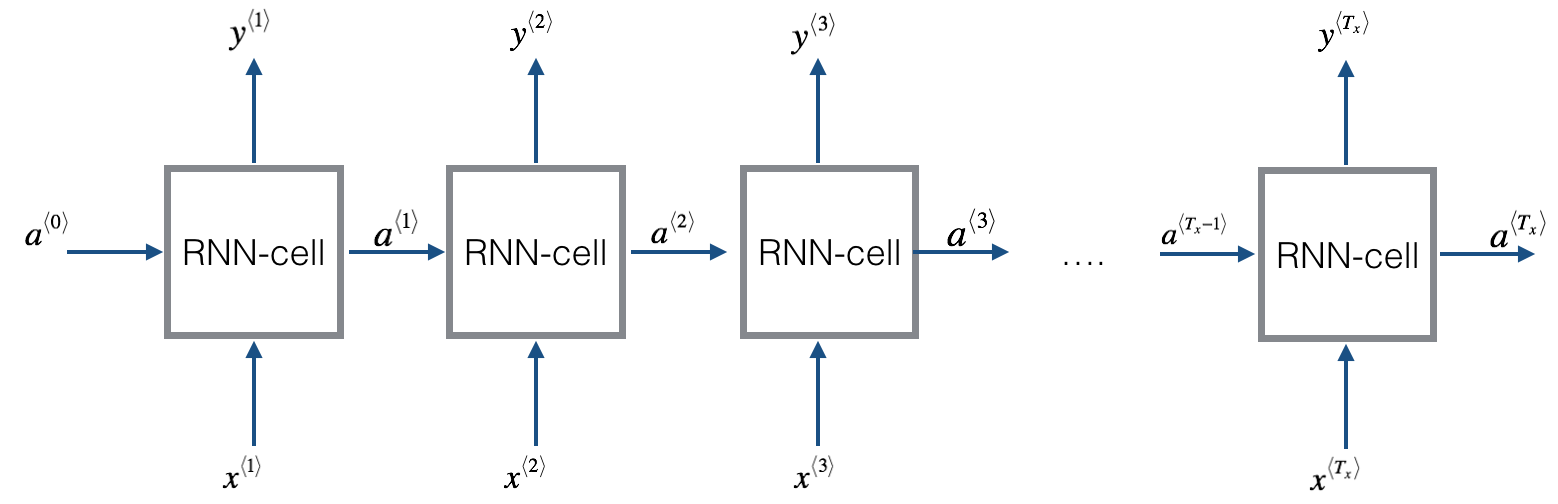

### Dimensions of input $x$

#### Input with $n_x$ number of units
* For a single time step of a single input example, $x^{(i) \langle t \rangle }$ is a one-dimensional input vector
* Using language as an example, a language with a 5000-word vocabulary could be one-hot encoded into a vector that has 5000 units.  So $x^{(i)\langle t \rangle}$ would have the shape (5000,)  
* The notation $n_x$ is used here to denote the number of units in a single time step of a single training example

#### Time steps of size $T_{x}$
* A recurrent neural network has multiple time steps, which we'll index with $t$.
* In this notebook, $T_{x}$ will denote the number of timesteps in the longest sequence.

#### Batches of size $m$
* Let's say we have mini-batches, each with 20 training examples  
* To benefit from vectorization, I stacked 20 columns of $x^{(i)}$ examples
* For example, this tensor has the shape (5000,20,10)
* I used $m$ to denote the number of training examples  
* So, the shape of a mini-batch is $(n_x,m,T_x)$

#### 3D Tensor of shape $(n_{x},m,T_{x})$
* The 3-dimensional tensor $x$ of shape $(n_x,m,T_x)$ represents the input $x$ that is fed into the RNN

#### Taking a 2D slice for each time step: $x^{\langle t \rangle}$
* At each time step, we'll use a mini-batch of training examples (not just a single example)
* So, for each time step $t$, we'll use a 2D slice of shape $(n_x,m)$
* This 2D slice was referred to as $x^{\langle t \rangle}$.  The variable name in the code is `xt`.

### Definition of hidden state $a$

* The activation $a^{\langle t \rangle}$ that is passed to the RNN from one time step to another is called a "hidden state."

### Dimensions of hidden state $a$

* Similar to the input tensor $x$, the hidden state for a single training example is a vector of length $n_{a}$
* If we include a mini-batch of $m$ training examples, the shape of a mini-batch is $(n_{a},m)$
* When I included the time step dimension, the shape of the hidden state is $(n_{a}, m, T_x)$
* I looped through the time steps with index $t$, and work with a 2D slice of the 3D tensor  
* This 2D slice is referred to as $a^{\langle t \rangle}$
* In my code, the variable names used are either `a_prev` or `a_next`, depending on the function being implemented
* The shape of this 2D slice is $(n_{a}, m)$

### Dimensions of prediction $\hat{y}$
* Similar to the inputs and hidden states, $\hat{y}$ is a 3D tensor of shape $(n_{y}, m, T_{y})$
    * $n_{y}$: number of units in the vector representing the prediction
    * $m$: number of examples in a mini-batch
    * $T_{y}$: number of time steps in the prediction
* For a single time step $t$, a 2D slice $\hat{y}^{\langle t \rangle}$ has shape $(n_{y}, m)$
* In my code, the variable names are:
    - `y_pred`: $\hat{y}$
    - `yt_pred`: $\hat{y}^{\langle t \rangle}$

Here's how I implemented an RNN:

### Steps:
1. Implement the calculations needed for one time step of the RNN.
2. Implement a loop over $T_x$ time steps in order to process all the inputs, one at a time.

<a name='1-1'></a>
### 1.1 - RNN Cell

We can think of the recurrent neural network as the repeated use of a single cell. First, I implemented the computations for a single time step. The following figure describes the operations for a single time step of an RNN cell:

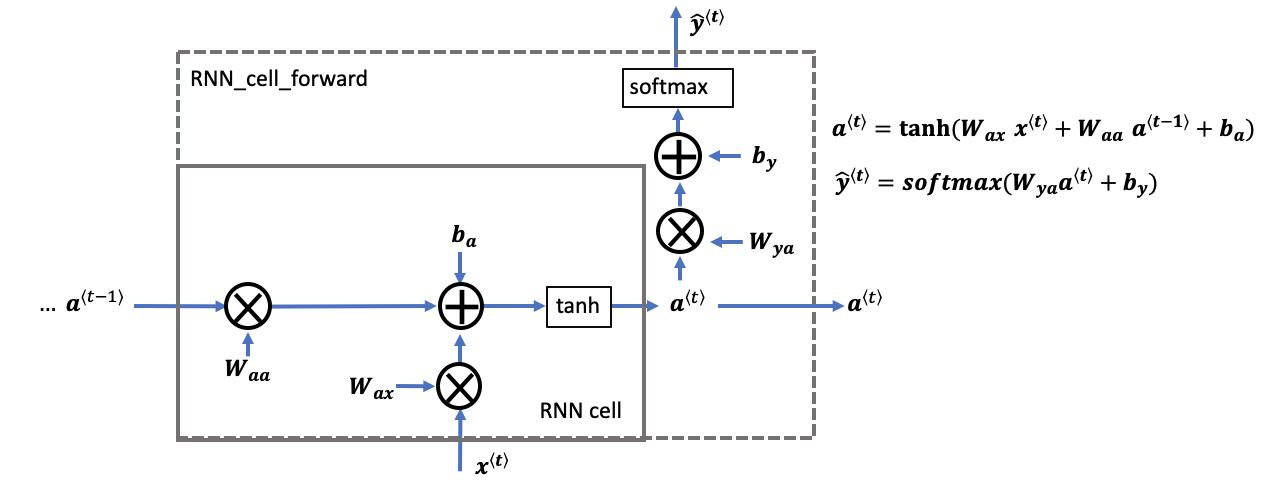


<caption><center><font color='purple'><b>Figure 2</b>: Basic RNN cell. Takes as input $x^{\langle t \rangle}$ (current input) and $a^{\langle t - 1\rangle}$ (previous hidden state containing information from the past), and outputs $a^{\langle t \rangle}$ which is given to the next RNN cell and also used to predict $\hat{y}^{\langle t \rangle}$
</center></caption>

In [ ]:
def rnn_cell_forward(xt, a_prev, parameters):
    """
    Implements a single forward step of the RNN-cell as described in Figure (2)

    Arguments:
    xt -- input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, a_prev, xt, parameters)
    """

    # Retrieve parameters from "parameters"
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]

    # compute next activation state using the formula given above
    a_next = np.tanh(np.dot(Waa, a_prev) + np.dot(Wax, xt) + ba)
    # compute output of the current cell using the formula given above
    yt_pred = softmax(np.dot(Wya, a_next) + by)

    # store values for backward propagation in cache
    cache = (a_next, a_prev, xt, parameters)

    return a_next, yt_pred, cache

<a name='1-2'></a>
### 1.2 - RNN Forward Pass

- A recurrent neural network (RNN) is a repetition of the RNN cell that we've just built.
    - If the input sequence of data is 10 time steps long, then we will re-use the RNN cell 10 times
- Each cell takes two inputs at each time step:
    - $a^{\langle t-1 \rangle}$: The hidden state from the previous cell
    - $x^{\langle t \rangle}$: The current time step's input data
- It has two outputs at each time step:
    - A hidden state ($a^{\langle t \rangle}$)
    - A prediction ($y^{\langle t \rangle}$)
- The weights and biases $(W_{aa}, b_{a}, W_{ax}, b_{x})$ are re-used each time step
    - They are maintained between calls to `rnn_cell_forward` in the 'parameters' dictionary


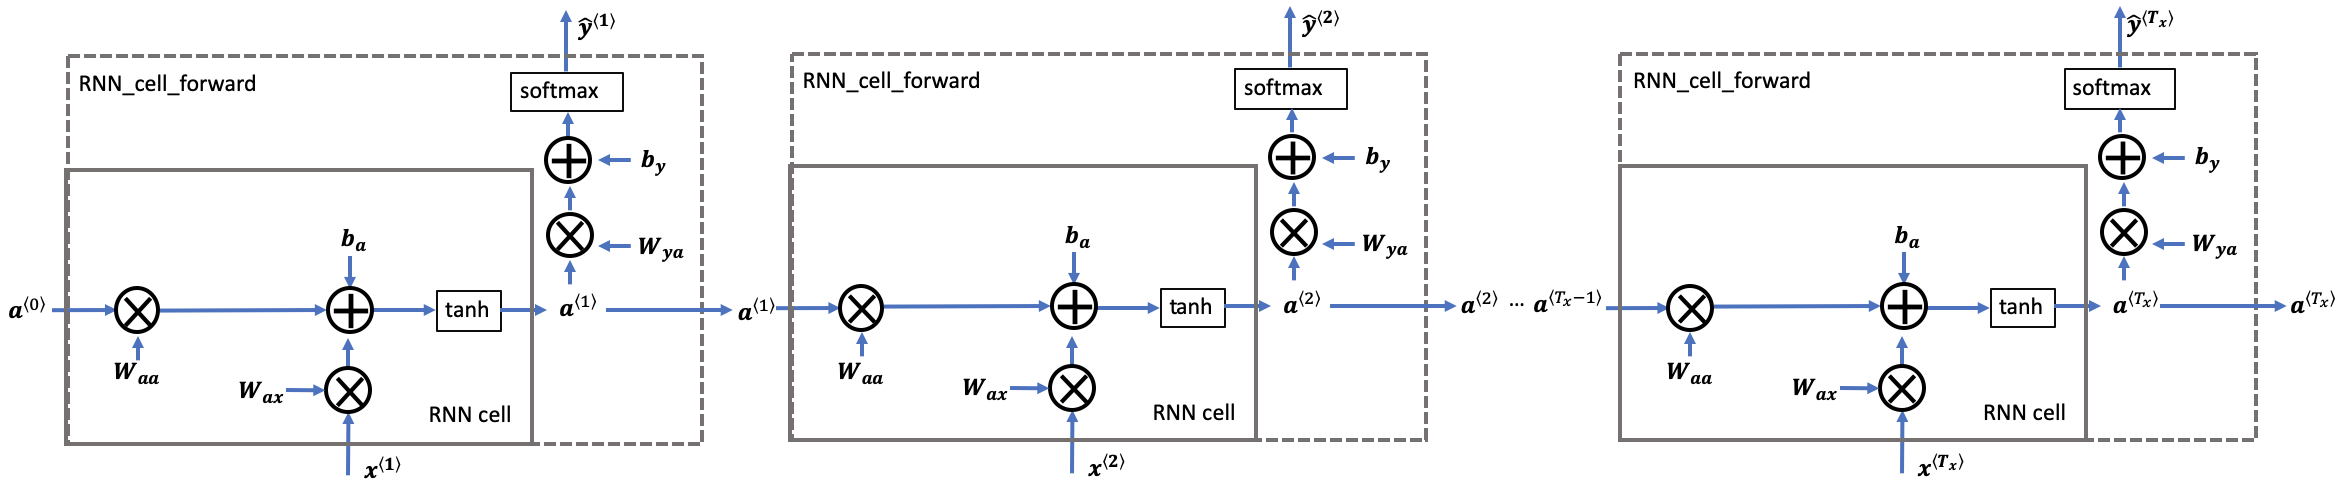
<caption><center><font color='purple'><b>Figure 3</b>: Basic RNN. The input sequence $x = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$  is carried over $T_x$ time steps. The network outputs $y = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$. </center></caption>


In [ ]:
def rnn_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network described in Figure (3).

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y_pred -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of caches, x)
    """

    # Initialize "caches" which will contain the list of all caches
    caches = []

    # Retrieve dimensions from shapes of x and parameters["Wya"]
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wya"].shape

    # initialize "a" and "y_pred" with zeros
    a = np.zeros((n_a, m, T_x))
    y_pred = np.zeros((n_y, m, T_x))

    # Initialize a_next
    a_next = a0

    # loop over all time-steps
    for t in range(T_x):
        # Update next hidden state, compute the prediction, get the cache
        a_next, yt_pred, cache = rnn_cell_forward(x[:, :, t], a_next, parameters)
        # Save the value of the new "next" hidden state in a
        a[:,:,t] = a_next
        # Save the value of the prediction in y
        y_pred[:,:,t] = yt_pred
        # Append "cache" to "caches"
        caches.append(cache)

    # store values needed for backward propagation in cache
    caches = (caches, x)

    return a, y_pred, caches

<a name='2'></a>
## 2 - Long Short-Term Memory (LSTM) Network

The following figure shows the operations of an LSTM cell:

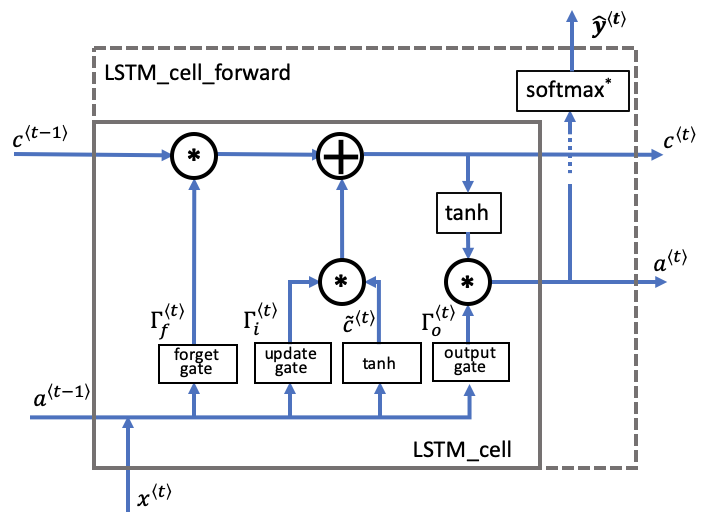
<caption><center><font color='purple'><b>Figure 4</b>: LSTM cell. This tracks and updates a "cell state," or memory variable $c^{\langle t \rangle}$ at every time step, which can be different from $a^{\langle t \rangle}$.  
Note, the $softmax^{}$ includes a dense layer and softmax.</center></caption>

Similar to the RNN example above, here I began by implementing the LSTM cell for a single time step. Then, I called it iteratively from inside a "for loop" to have it process an input with $T_x$ time steps.

### Overview of gates and states

#### Forget gate $\mathbf{\Gamma}_{f}$

* Let's assume we are reading words in a piece of text, and plan to use an LSTM to keep track of grammatical structures, such as whether the subject is singular ("puppy") or plural ("puppies").
* If the subject changes its state (from a singular word to a plural word), the memory of the previous state becomes outdated, so we'll "forget" that outdated state.
* The "forget gate" is a tensor containing values between 0 and 1.
    * If a unit in the forget gate has a value close to 0, the LSTM will "forget" the stored state in the corresponding unit of the previous cell state.
    * If a unit in the forget gate has a value close to 1, the LSTM will mostly remember the corresponding value in the stored state.

##### Equation

$$\mathbf{\Gamma}_f^{\langle t \rangle} = \sigma(\mathbf{W}_f[\mathbf{a}^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_f)\tag{1} $$

##### Explanation of the equation:

* $\mathbf{W_{f}}$ contains weights that govern the forget gate's behavior.
* The previous time step's hidden state $[a^{\langle t-1 \rangle}$ and current time step's input $x^{\langle t \rangle}]$ are concatenated together and multiplied by $\mathbf{W_{f}}$.
* A sigmoid function is used to make each of the gate tensor's values $\mathbf{\Gamma}_f^{\langle t \rangle}$ range from 0 to 1.
* The forget gate  $\mathbf{\Gamma}_f^{\langle t \rangle}$ has the same dimensions as the previous cell state $c^{\langle t-1 \rangle}$.
* This means that the two can be multiplied together, element-wise.
* Multiplying the tensors $\mathbf{\Gamma}_f^{\langle t \rangle} * \mathbf{c}^{\langle t-1 \rangle}$ is like applying a mask over the previous cell state.
* If a single value in $\mathbf{\Gamma}_f^{\langle t \rangle}$ is 0 or close to 0, then the product is close to 0.
    * This keeps the information stored in the corresponding unit in $\mathbf{c}^{\langle t-1 \rangle}$ from being remembered for the next time step.
* Similarly, if one value is close to 1, the product is close to the original value in the previous cell state.
    * The LSTM will keep the information from the corresponding unit of $\mathbf{c}^{\langle t-1 \rangle}$, to be used in the next time step.
    
##### Variable names in the code
The variable names in the code are similar to the equations, with slight differences.  
* `Wf`: forget gate weight $\mathbf{W}_{f}$
* `bf`: forget gate bias $\mathbf{b}_{f}$
* `ft`: forget gate $\Gamma_f^{\langle t \rangle}$

#### Candidate value $\tilde{\mathbf{c}}^{\langle t \rangle}$
* The candidate value is a tensor containing information from the current time step that **may** be stored in the current cell state $\mathbf{c}^{\langle t \rangle}$.
* The parts of the candidate value that get passed on depend on the update gate.
* The candidate value is a tensor containing values that range from -1 to 1.
* The tilde "~" is used to differentiate the candidate $\tilde{\mathbf{c}}^{\langle t \rangle}$ from the cell state $\mathbf{c}^{\langle t \rangle}$.

##### Equation
$$\mathbf{\tilde{c}}^{\langle t \rangle} = \tanh\left( \mathbf{W}_{c} [\mathbf{a}^{\langle t - 1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_{c} \right) \tag{3}$$

##### Explanation of the equation
* The *tanh* function produces values between -1 and 1.


##### Variable names in the code
* `cct`: candidate value $\mathbf{\tilde{c}}^{\langle t \rangle}$

#### Update gate $\mathbf{\Gamma}_{i}$

* I used the update gate to decide what aspects of the candidate $\tilde{\mathbf{c}}^{\langle t \rangle}$ to add to the cell state $c^{\langle t \rangle}$.
* The update gate decides what parts of a "candidate" tensor $\tilde{\mathbf{c}}^{\langle t \rangle}$ are passed onto the cell state $\mathbf{c}^{\langle t \rangle}$.
* The update gate is a tensor containing values between 0 and 1.
    * When a unit in the update gate is close to 1, it allows the value of the candidate $\tilde{\mathbf{c}}^{\langle t \rangle}$ to be passed onto the hidden state $\mathbf{c}^{\langle t \rangle}$
    * When a unit in the update gate is close to 0, it prevents the corresponding value in the candidate from being passed onto the hidden state.
* Notice that the subscript "i" is used and not "u", to follow the convention used in the literature.

##### Equation

$$\mathbf{\Gamma}_i^{\langle t \rangle} = \sigma(\mathbf{W}_i[a^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_i)\tag{2} $$

##### Explanation of the equation

* Similar to the forget gate, here $\mathbf{\Gamma}_i^{\langle t \rangle}$, the sigmoid produces values between 0 and 1.
* The update gate is multiplied element-wise with the candidate, and this product ($\mathbf{\Gamma}_{i}^{\langle t \rangle} * \tilde{c}^{\langle t \rangle}$) is used in determining the cell state $\mathbf{c}^{\langle t \rangle}$.

##### Variable names in code (Please note that they're different than the equations)
In the code, we'll use the variable names found in the academic literature.  These variables don't use "u" to denote "update".
* `Wi` is the update gate weight $\mathbf{W}_i$ (not "Wu")
* `bi` is the update gate bias $\mathbf{b}_i$ (not "bu")
* `it` is the forget gate $\mathbf{\Gamma}_i^{\langle t \rangle}$ (not "ut")

#### Cell state $\mathbf{c}^{\langle t \rangle}$

* The cell state is the "memory" that gets passed onto future time steps.
* The new cell state $\mathbf{c}^{\langle t \rangle}$ is a combination of the previous cell state and the candidate value.

##### Equation

$$ \mathbf{c}^{\langle t \rangle} = \mathbf{\Gamma}_f^{\langle t \rangle}* \mathbf{c}^{\langle t-1 \rangle} + \mathbf{\Gamma}_{i}^{\langle t \rangle} *\mathbf{\tilde{c}}^{\langle t \rangle} \tag{4} $$

##### Explanation of equation
* The previous cell state $\mathbf{c}^{\langle t-1 \rangle}$ is adjusted (weighted) by the forget gate $\mathbf{\Gamma}_{f}^{\langle t \rangle}$
* and the candidate value $\tilde{\mathbf{c}}^{\langle t \rangle}$, adjusted (weighted) by the update gate $\mathbf{\Gamma}_{i}^{\langle t \rangle}$

##### Variable names and shapes in the code
* `c`: cell state, including all time steps, $\mathbf{c}$ shape $(n_{a}, m, T_x)$
* `c_next`: new (next) cell state, $\mathbf{c}^{\langle t \rangle}$ shape $(n_{a}, m)$
* `c_prev`: previous cell state, $\mathbf{c}^{\langle t-1 \rangle}$, shape $(n_{a}, m)$

#### Output gate $\mathbf{\Gamma}_{o}$

* The output gate decides what gets sent as the prediction (output) of the time step.
* The output gate is like the other gates, in that it contains values that range from 0 to 1.

##### Equation

$$ \mathbf{\Gamma}_o^{\langle t \rangle}=  \sigma(\mathbf{W}_o[\mathbf{a}^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_{o})\tag{5}$$

##### Explanation of the equation
* The output gate is determined by the previous hidden state $\mathbf{a}^{\langle t-1 \rangle}$ and the current input $\mathbf{x}^{\langle t \rangle}$
* The sigmoid makes the gate range from 0 to 1.


##### Variable names in the code
* `Wo`: output gate weight, $\mathbf{W_o}$
* `bo`: output gate bias, $\mathbf{b_o}$
* `ot`: output gate, $\mathbf{\Gamma}_{o}^{\langle t \rangle}$

#### Hidden state $\mathbf{a}^{\langle t \rangle}$

* The hidden state gets passed to the LSTM cell's next time step.
* It is used to determine the three gates ($\mathbf{\Gamma}_{f}, \mathbf{\Gamma}_{u}, \mathbf{\Gamma}_{o}$) of the next time step.
* The hidden state is also used for the prediction $y^{\langle t \rangle}$.

##### Equation

$$ \mathbf{a}^{\langle t \rangle} = \mathbf{\Gamma}_o^{\langle t \rangle} * \tanh(\mathbf{c}^{\langle t \rangle})\tag{6} $$

##### Explanation of equation
* The hidden state $\mathbf{a}^{\langle t \rangle}$ is determined by the cell state $\mathbf{c}^{\langle t \rangle}$ in combination with the output gate $\mathbf{\Gamma}_{o}$.
* The cell state state is passed through the `tanh` function to rescale values between -1 and 1.
* The output gate acts like a "mask" that either preserves the values of $\tanh(\mathbf{c}^{\langle t \rangle})$ or keeps those values from being included in the hidden state $\mathbf{a}^{\langle t \rangle}$

##### Variable names  and shapes in the code
* `a`: hidden state, including time steps.  $\mathbf{a}$ has shape $(n_{a}, m, T_{x})$
* `a_prev`: hidden state from previous time step. $\mathbf{a}^{\langle t-1 \rangle}$ has shape $(n_{a}, m)$
* `a_next`: hidden state for next time step.  $\mathbf{a}^{\langle t \rangle}$ has shape $(n_{a}, m)$

#### Prediction $\mathbf{y}^{\langle t \rangle}_{pred}$
* The prediction in this use case is a classification, so we'll use a softmax.

The equation is:
$$\mathbf{y}^{\langle t \rangle}_{pred} = \textrm{softmax}(\mathbf{W}_{y} \mathbf{a}^{\langle t \rangle} + \mathbf{b}_{y})$$

##### Variable names and shapes in the code
* `y_pred`: prediction, including all time steps. $\mathbf{y}_{pred}$ has shape $(n_{y}, m, T_{x})$.  Note that $(T_{y} = T_{x})$ for this example.
* `yt_pred`: prediction for the current time step $t$. $\mathbf{y}^{\langle t \rangle}_{pred}$ has shape $(n_{y}, m)$

<a name='2-1'></a>
### 2.1 - LSTM Cell

In [ ]:
def lstm_cell_forward(xt, a_prev, c_prev, parameters):
    """
    Implement a single forward step of the LSTM-cell as described in Figure (4)

    Arguments:
    xt -- input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    c_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo --  Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    c_next -- next memory state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, c_next, a_prev, c_prev, xt, parameters)

    Note: ft/it/ot stand for the forget/update/output gates, cct stands for the candidate value (c tilde),
          c stands for the cell state (memory)
    """

    # Retrieve parameters from "parameters"
    Wf = parameters["Wf"] # forget gate weight
    bf = parameters["bf"]
    Wi = parameters["Wi"] # update gate weight (notice the variable name)
    bi = parameters["bi"] # (notice the variable name)
    Wc = parameters["Wc"] # candidate value weight
    bc = parameters["bc"]
    Wo = parameters["Wo"] # output gate weight
    bo = parameters["bo"]
    Wy = parameters["Wy"] # prediction weight
    by = parameters["by"]

    # Retrieve dimensions from shapes of xt and Wy
    n_x, m = xt.shape
    n_y, n_a = Wy.shape

    # Concatenate a_prev and xt
    concat = np.concatenate((a_prev, xt))

    # Compute values for ft, it, cct, c_next, ot, a_next using the formulas given figure (4)
    ft = sigmoid(np.dot(Wf, concat) + bf)
    it = sigmoid(np.dot(Wi, concat) + bi)
    cct = np.tanh(np.dot(Wc, concat) + bc)
    c_next = ft * c_prev + it * cct
    ot = sigmoid(np.dot(Wo, concat) + bo)
    a_next = ot * np.tanh(c_next)

    # Compute prediction of the LSTM cell
    yt_pred = softmax(np.dot(Wy, a_next) + by)

    # store values needed for backward propagation in cache
    cache = (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters)

    return a_next, c_next, yt_pred, cache

<a name='2-2'></a>
### 2.2 - Forward Pass for LSTM

Now that we have implemented one step of an LSTM, can iterate this over it using a for loop to process a sequence of $T_x$ inputs.

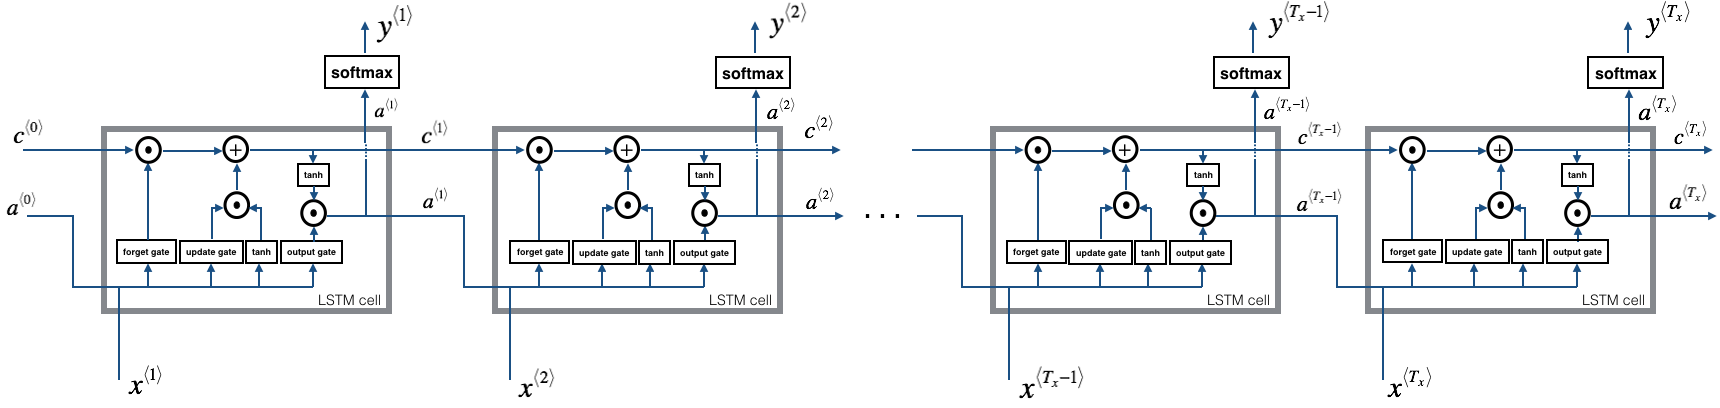
<caption><center><font color='purple'><b>Figure 5</b>: LSTM over multiple time steps. </center></caption>

    
To implement `lstm_forward()` to run an LSTM over $T_x$ time steps, I followed the following steps:
* Get the dimensions $n_x, n_a, n_y, m, T_x$ from the shape of the variables: `x` and `parameters`
* Initialize the 3D tensors $a$, $c$ and $y$
    - $a$: hidden state, shape $(n_{a}, m, T_{x})$
    - $c$: cell state, shape $(n_{a}, m, T_{x})$
    - $y$: prediction, shape $(n_{y}, m, T_{x})$ (Note that $T_{y} = T_{x}$ in this example)
    - **Note** Setting one variable equal to the other is a "copy by reference".  In other words, don't do `c = a', otherwise both these variables point to the same underlying variable.
* Initialize the 2D tensor $a^{\langle t \rangle}$
    - $a^{\langle t \rangle}$ stores the hidden state for time step $t$.  The variable name is `a_next`.
    - $a^{\langle 0 \rangle}$, the initial hidden state at time step 0, is passed in when calling the function. The variable name is `a0`.
    - $a^{\langle t \rangle}$ and $a^{\langle 0 \rangle}$ represent a single time step, so they both have the shape  $(n_{a}, m)$
    - Initialize $a^{\langle t \rangle}$ by setting it to the initial hidden state ($a^{\langle 0 \rangle}$) that is passed into the function.
* Initialize $c^{\langle t \rangle}$ with zeros.
    - The variable name is `c_next`
    - $c^{\langle t \rangle}$ represents a single time step, so its shape is $(n_{a}, m)$
    - **Note**: create `c_next` as its own variable with its own location in memory.  Do not initialize it as a slice of the 3D tensor $c$.  In other words, **don't** do `c_next = c[:,:,0]`.
* For each time step, do the following:
    - From the 3D tensor $x$, get a 2D slice $x^{\langle t \rangle}$ at time step $t$
    - Call the `lstm_cell_forward` function that defined previously, to get the hidden state, cell state, prediction, and cache
    - Store the hidden state, cell state and prediction (the 2D tensors) inside the 3D tensors
    - Append the cache to the list of caches

In [ ]:
def lstm_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network using an LSTM-cell described in Figure (4).

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc -- Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo -- Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    c -- The value of the cell state, numpy array of shape (n_a, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of all the caches, x)
    """

    # Initialize "caches", which will track the list of all the caches
    caches = []

    Wy = parameters['Wy'] # saving parameters['Wy'] in a local variable in case students use Wy instead of parameters['Wy']
    # Retrieve dimensions from shapes of x and parameters['Wy']
    n_x, m, T_x = x.shape
    n_y, n_a = Wy.shape

    # initialize "a", "c" and "y" with zeros
    a = np.zeros((n_a, m, T_x))
    c = np.zeros((n_a, m, T_x))
    y = np.zeros((n_y, m, T_x))

    # Initialize a_next and c_next
    a_next = a0
    c_next = np.zeros(a_next.shape)

    # loop over all time-steps
    for t in range(T_x):
        # Get the 2D slice 'xt' from the 3D input 'x' at time step 't'
        xt = x[:,:,t]
        # Update next hidden state, next memory state, compute the prediction, get the cache
        a_next, c_next, yt, cache = lstm_cell_forward(xt, a_next, c_next, parameters)
        # Save the value of the new "next" hidden state in a
        a[:,:,t] = a_next
        # Save the value of the next cell state
        c[:,:,t]  = c_next
        # Save the value of the prediction in y
        y[:,:,t] = yt
        # Append the cache into caches
        caches.append(cache)

    # store values needed for backward propagation in cache
    caches = (caches, x)

    return a, y, c, caches

<a name='3'></a>    
## 3 - Backpropagation in Recurrent Neural Networks

Note that this notebook does not implement the backward path from the Loss 'J' backwards to 'a'. This would have included the dense layer and softmax, which are a part of the forward path. This is assumed to be calculated elsewhere and the result passed to `rnn_backward` in 'da'. It is further assumed that loss has been adjusted for batch size (m) and division by the number of examples is not required here.

<a name='3-1'></a>    
### 3.1 - Basic RNN  Backward Pass

Begin by computing the backward pass for the basic RNN cell. Then, in the following sections, iterate through the cells.

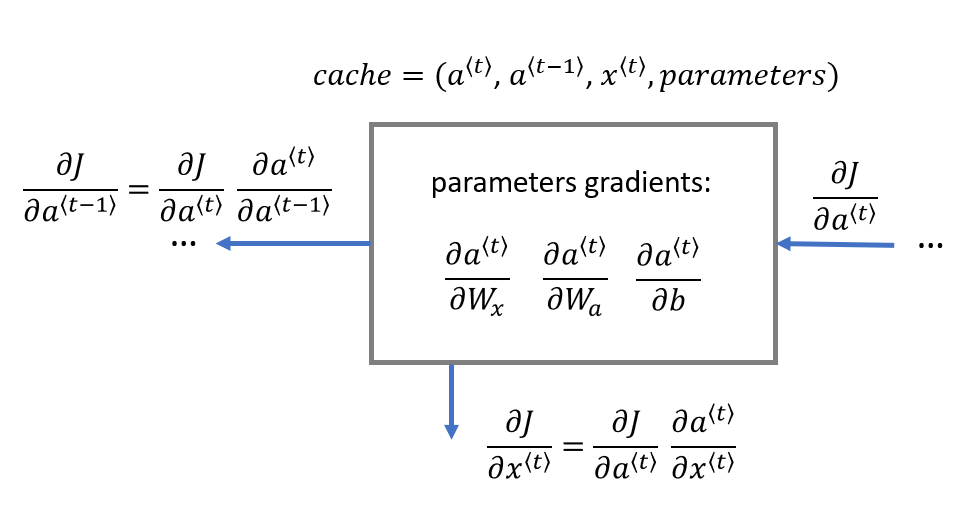
<caption><center><font color='purple'><b>Figure 6</b>: The RNN cell's backward pass. Just like in a fully-connected neural network, the derivative of the cost function $J$ backpropagates through the time steps of the RNN by following the chain rule from calculus. Internal to the cell, the chain rule is also used to calculate $(\frac{\partial J}{\partial W_{ax}},\frac{\partial J}{\partial W_{aa}},\frac{\partial J}{\partial b})$ to update the parameters $(W_{ax}, W_{aa}, b_a)$. The operation can utilize the cached results from the forward path. </center></caption>

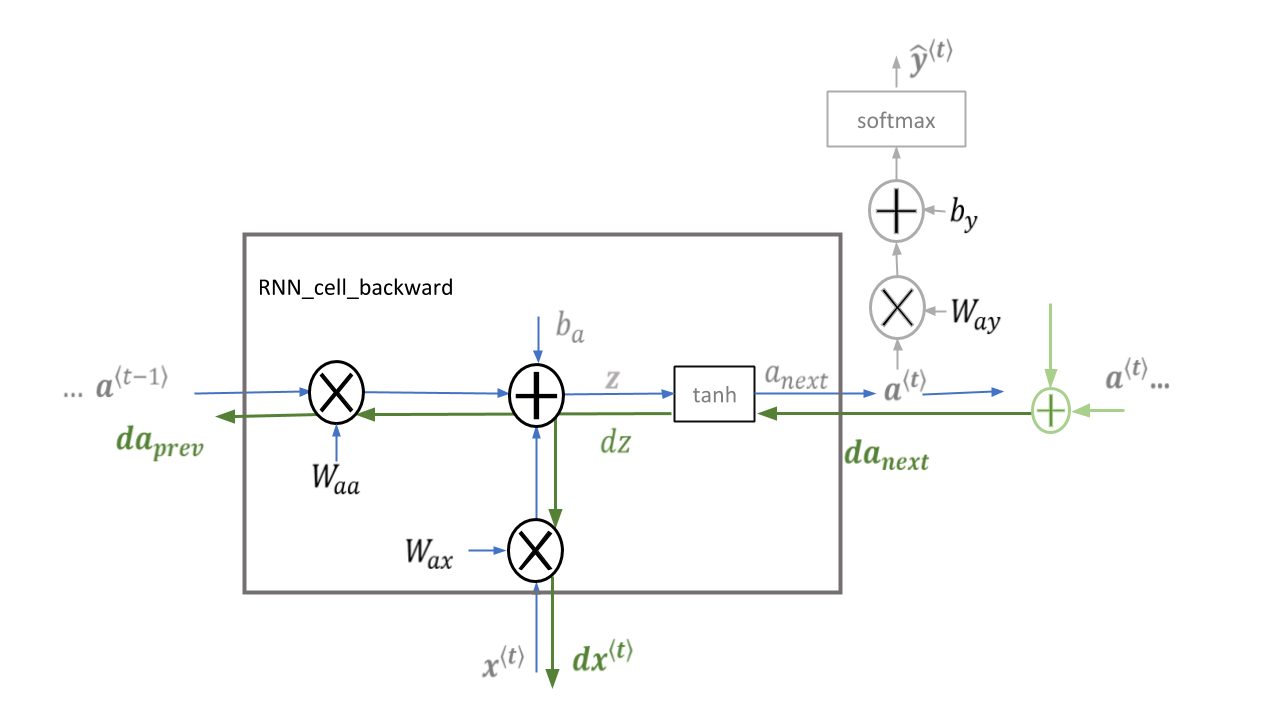
<caption><center><font color='purple'><b>Figure 7</b>: This implementation of `rnn_cell_backward` does **not** include the output dense layer and softmax which are included in `rnn_cell_forward`.  

$da_{next}$ is $\frac{\partial{J}}{\partial a^{\langle t \rangle}}$ and includes loss from previous stages and current stage output logic. The addition shown in green will be part of the implementation of `rnn_backward`.  </center></caption>

##### Equations
To compute `rnn_cell_backward`, I used the following equations. Here, $*$ denotes element-wise multiplication while the absence of a symbol indicates matrix multiplication.

\begin{align}
\displaystyle a^{\langle t \rangle} &= \tanh(W_{ax} x^{\langle t \rangle} + W_{aa} a^{\langle t-1 \rangle} + b_{a})\tag{-} \\[8pt]
\displaystyle \frac{\partial \tanh(x)} {\partial x} &= 1 - \tanh^2(x) \tag{-} \\[8pt]
\displaystyle {dtanh} &= da_{next} * ( 1 - \tanh^2(W_{ax}x^{\langle t \rangle}+W_{aa} a^{\langle t-1 \rangle} + b_{a})) \tag{0} \\[8pt]
\displaystyle  {dW_{ax}} &= dtanh \cdot x^{\langle t \rangle T}\tag{1} \\[8pt]
\displaystyle dW_{aa} &= dtanh \cdot a^{\langle t-1 \rangle T}\tag{2} \\[8pt]
\displaystyle db_a& = \sum_{batch}dtanh\tag{3} \\[8pt]
\displaystyle dx^{\langle t \rangle} &= { W_{ax}}^T \cdot dtanh\tag{4} \\[8pt]
\displaystyle da_{prev} &= { W_{aa}}^T \cdot dtanh\tag{5}
\end{align}



In [ ]:
def rnn_cell_backward(da_next, cache):
    """
    Implements the backward pass for the RNN-cell (single time-step).

    Arguments:
    da_next -- Gradient of loss with respect to next hidden state
    cache -- python dictionary containing useful values (output of rnn_cell_forward())

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradients of input data, of shape (n_x, m)
                        da_prev -- Gradients of previous hidden state, of shape (n_a, m)
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dba -- Gradients of bias vector, of shape (n_a, 1)
    """

    # Retrieve values from cache
    (a_next, a_prev, xt, parameters) = cache

    # Retrieve values from parameters
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]

    # compute the gradient of tanh with respect to a_next
    dtanh = (1 - a_next ** 2) * da_next

    # compute the gradient of the loss with respect to Wax
    dxt = np.dot(Wax.T, dtanh)
    dWax = np.dot(dtanh, xt.T)

    # compute the gradient with respect to Waa
    da_prev = np.dot(Waa.T, dtanh)
    dWaa = np.dot(dtanh, a_prev.T)

    # compute the gradient with respect to b
    dba = np.sum(dtanh, axis = 1,keepdims=1)

    # Store the gradients in a python dictionary
    gradients = {"dxt": dxt, "da_prev": da_prev, "dWax": dWax, "dWaa": dWaa, "dba": dba}

    return gradients

In [ ]:
np.random.seed(1)
xt_tmp = np.random.randn(3,10)
a_prev_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Wax'] = np.random.randn(5,3)
parameters_tmp['Waa'] = np.random.randn(5,5)
parameters_tmp['Wya'] = np.random.randn(2,5)
parameters_tmp['ba'] = np.random.randn(5,1)
parameters_tmp['by'] = np.random.randn(2,1)

a_next_tmp, yt_tmp, cache_tmp = rnn_cell_forward(xt_tmp, a_prev_tmp, parameters_tmp)

da_next_tmp = np.random.randn(5,10)
gradients_tmp = rnn_cell_backward(da_next_tmp, cache_tmp)
print("gradients[\"dxt\"][1][2] =", gradients_tmp["dxt"][1][2])
print("gradients[\"dxt\"].shape =", gradients_tmp["dxt"].shape)
print("gradients[\"da_prev\"][2][3] =", gradients_tmp["da_prev"][2][3])
print("gradients[\"da_prev\"].shape =", gradients_tmp["da_prev"].shape)
print("gradients[\"dWax\"][3][1] =", gradients_tmp["dWax"][3][1])
print("gradients[\"dWax\"].shape =", gradients_tmp["dWax"].shape)
print("gradients[\"dWaa\"][1][2] =", gradients_tmp["dWaa"][1][2])
print("gradients[\"dWaa\"].shape =", gradients_tmp["dWaa"].shape)
print("gradients[\"dba\"][4] =", gradients_tmp["dba"][4])
print("gradients[\"dba\"].shape =", gradients_tmp["dba"].shape)

gradients["dxt"][1][2] = -1.3872130506020925
gradients["dxt"].shape = (3, 10)
gradients["da_prev"][2][3] = -0.15239949377395495
gradients["da_prev"].shape = (5, 10)
gradients["dWax"][3][1] = 0.4107728249354584
gradients["dWax"].shape = (5, 3)
gradients["dWaa"][1][2] = 1.1503450668497135
gradients["dWaa"].shape = (5, 5)
gradients["dba"][4] = [0.20023491]
gradients["dba"].shape = (5, 1)


* Note that this notebook does not implement the backward path from the Loss 'J' backwards to 'a'.
    * This would have included the dense layer and softmax which are a part of the forward path.
    * This is assumed to be calculated elsewhere and the result passed to `rnn_backward` in 'da'.
    * We must combine this with the loss from the previous stages when calling `rnn_cell_backward` (see figure 7 above).
* It is further assumed that loss has been adjusted for batch size (m).
    * Therefore, division by the number of examples is not required here.

In [ ]:
def rnn_backward(da, caches):
    """
    Implement the backward pass for a RNN over an entire sequence of input data.

    Arguments:
    da -- Upstream gradients of all hidden states, of shape (n_a, m, T_x)
    caches -- tuple containing information from the forward pass (rnn_forward)

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient w.r.t. the input data, numpy-array of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t the initial hidden state, numpy-array of shape (n_a, m)
                        dWax -- Gradient w.r.t the input's weight matrix, numpy-array of shape (n_a, n_x)
                        dWaa -- Gradient w.r.t the hidden state's weight matrix, numpy-arrayof shape (n_a, n_a)
                        dba -- Gradient w.r.t the bias, of shape (n_a, 1)
    """

    # Retrieve values from the first cache (t=1) of caches
    (caches, x) = caches
    (a1, a0, x1, parameters) = caches[0]

    # Retrieve dimensions from da's and x1's shapes
    n_a, m, T_x = da.shape
    n_x, m = x1.shape

    # initialize the gradients with the right sizes
    dx = np.zeros((n_x, m, T_x))
    dWax = np.zeros((n_a, n_x))
    dWaa = np.zeros((n_a, n_a))
    dba = np.zeros((n_a, 1))
    da0 = np.zeros((n_a, m))
    da_prevt = np.zeros((n_a, m))


    # Loop through all the time steps
    for t in reversed(range(T_x)):
        # Compute gradients at time step t. Choose wisely the "da_next" and the "cache" to use in the backward propagation step
        gradients = rnn_cell_backward(da[:,:,t] + da_prevt, caches[t])
        # Retrieve derivatives from gradients
        dxt, da_prevt, dWaxt, dWaat, dbat = gradients["dxt"], gradients["da_prev"], gradients["dWax"], gradients["dWaa"], gradients["dba"]
        # Increment global derivatives w.r.t parameters by adding their derivative at time-step t
        dx[:, :, t] = dxt
        dWax += dWaxt
        dWaa += dWaat
        dba += dbat

    # Set da0 to the gradient of a which has been backpropagated through all time-steps
    da0 = da_prevt

    # Store the gradients in a python dictionary
    gradients = {"dx": dx, "da0": da0, "dWax": dWax, "dWaa": dWaa,"dba": dba}

    return gradients

In [ ]:
np.random.seed(1)
x_tmp = np.random.randn(3,10,4)
a0_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Wax'] = np.random.randn(5,3)
parameters_tmp['Waa'] = np.random.randn(5,5)
parameters_tmp['Wya'] = np.random.randn(2,5)
parameters_tmp['ba'] = np.random.randn(5,1)
parameters_tmp['by'] = np.random.randn(2,1)

a_tmp, y_tmp, caches_tmp = rnn_forward(x_tmp, a0_tmp, parameters_tmp)
da_tmp = np.random.randn(5, 10, 4)
gradients_tmp = rnn_backward(da_tmp, caches_tmp)

print("gradients[\"dx\"][1][2] =", gradients_tmp["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients_tmp["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients_tmp["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients_tmp["da0"].shape)
print("gradients[\"dWax\"][3][1] =", gradients_tmp["dWax"][3][1])
print("gradients[\"dWax\"].shape =", gradients_tmp["dWax"].shape)
print("gradients[\"dWaa\"][1][2] =", gradients_tmp["dWaa"][1][2])
print("gradients[\"dWaa\"].shape =", gradients_tmp["dWaa"].shape)
print("gradients[\"dba\"][4] =", gradients_tmp["dba"][4])
print("gradients[\"dba\"].shape =", gradients_tmp["dba"].shape)

gradients["dx"][1][2] = [-2.07101689 -0.59255627  0.02466855  0.01483317]
gradients["dx"].shape = (3, 10, 4)
gradients["da0"][2][3] = -0.31494237512664996
gradients["da0"].shape = (5, 10)
gradients["dWax"][3][1] = 11.264104496527777
gradients["dWax"].shape = (5, 3)
gradients["dWaa"][1][2] = 2.303333126579893
gradients["dWaa"].shape = (5, 5)
gradients["dba"][4] = [-0.74747722]
gradients["dba"].shape = (5, 1)


<a name='3-2'></a>
### 3.2 - LSTM Backward Pass

#### 1. One Step Backward
The LSTM backward pass was slightly more complicated than the forward pass.

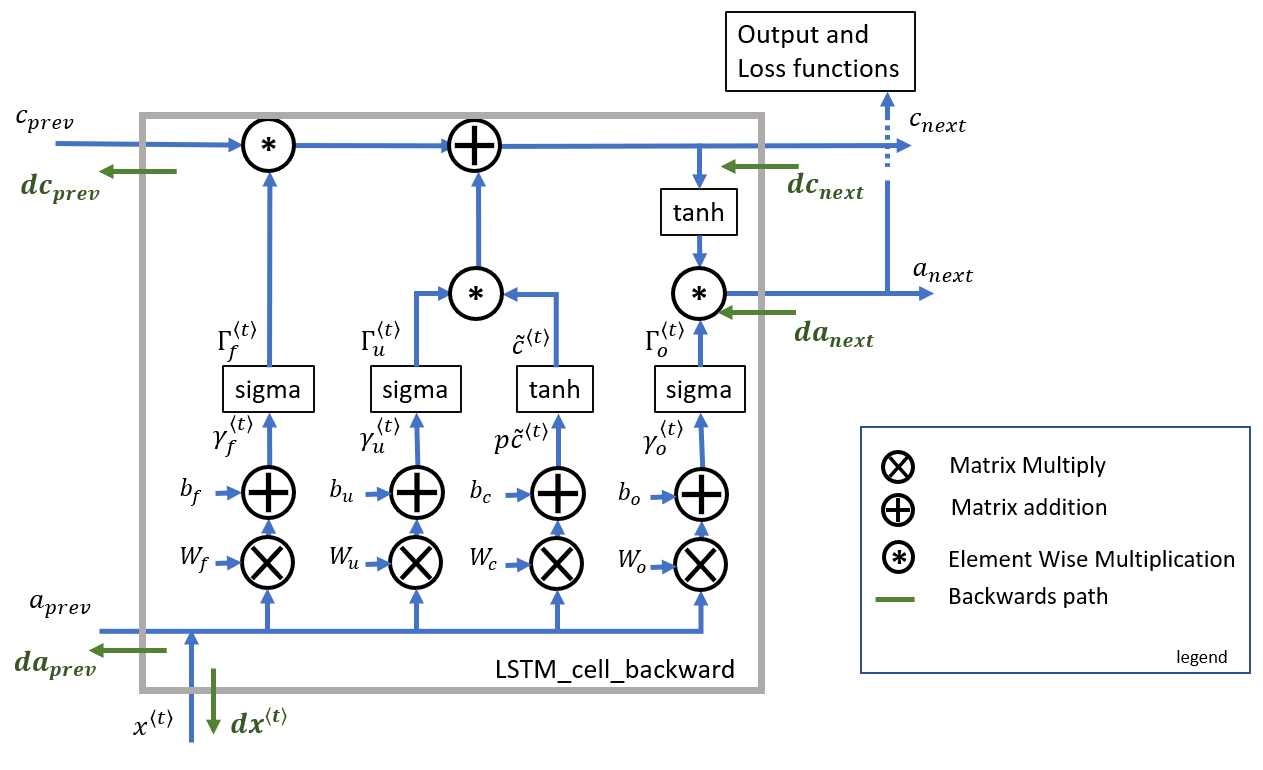
<caption><center><font color='purple'><b>Figure 8</b>: LSTM Cell Backward. Note the output functions, while part of the `lstm_cell_forward`, are not included in `lstm_cell_backward` </center></caption>

I provided the equations for the LSTM backward pass below.

#### 2. Gate Derivatives
Note the location of the gate derivatives ($\gamma$..) between the dense layer and the activation function (see graphic above). This is convenient for computing parameter derivatives in the next step.
\begin{align}
d\gamma_o^{\langle t \rangle} &= da_{next}*\tanh(c_{next}) * \Gamma_o^{\langle t \rangle}*\left(1-\Gamma_o^{\langle t \rangle}\right)\tag{7} \\[8pt]
dp\widetilde{c}^{\langle t \rangle} &= \left(dc_{next}*\Gamma_u^{\langle t \rangle}+ \Gamma_o^{\langle t \rangle}* (1-\tanh^2(c_{next})) * \Gamma_u^{\langle t \rangle} * da_{next} \right) * \left(1-\left(\widetilde c^{\langle t \rangle}\right)^2\right) \tag{8} \\[8pt]
d\gamma_u^{\langle t \rangle} &= \left(dc_{next}*\widetilde{c}^{\langle t \rangle} + \Gamma_o^{\langle t \rangle}* (1-\tanh^2(c_{next})) * \widetilde{c}^{\langle t \rangle} * da_{next}\right)*\Gamma_u^{\langle t \rangle}*\left(1-\Gamma_u^{\langle t \rangle}\right)\tag{9} \\[8pt]
d\gamma_f^{\langle t \rangle} &= \left(dc_{next}* c_{prev} + \Gamma_o^{\langle t \rangle} * (1-\tanh^2(c_{next})) * c_{prev} * da_{next}\right)*\Gamma_f^{\langle t \rangle}*\left(1-\Gamma_f^{\langle t \rangle}\right)\tag{10}
\end{align}

#### 3. Parameter Derivatives

$ dW_f = d\gamma_f^{\langle t \rangle} \begin{bmatrix} a_{prev} \\ x_t\end{bmatrix}^T \tag{11} $
$ dW_u = d\gamma_u^{\langle t \rangle} \begin{bmatrix} a_{prev} \\ x_t\end{bmatrix}^T \tag{12} $
$ dW_c = dp\widetilde c^{\langle t \rangle} \begin{bmatrix} a_{prev} \\ x_t\end{bmatrix}^T \tag{13} $
$ dW_o = d\gamma_o^{\langle t \rangle} \begin{bmatrix} a_{prev} \\ x_t\end{bmatrix}^T \tag{14}$

To calculate $db_f, db_u, db_c, db_o$ we just need to sum across all 'm' examples (axis= 1) on $d\gamma_f^{\langle t \rangle}, d\gamma_u^{\langle t \rangle}, dp\widetilde c^{\langle t \rangle}, d\gamma_o^{\langle t \rangle}$ respectively. Note that we should have the `keepdims = True` option.

$\displaystyle db_f = \sum_{batch}d\gamma_f^{\langle t \rangle}\tag{15}$
$\displaystyle db_u = \sum_{batch}d\gamma_u^{\langle t \rangle}\tag{16}$
$\displaystyle db_c = \sum_{batch}d\gamma_c^{\langle t \rangle}\tag{17}$
$\displaystyle db_o = \sum_{batch}d\gamma_o^{\langle t \rangle}\tag{18}$

Finally, I will compute the derivative with respect to the previous hidden state, previous memory state, and input.

$ da_{prev} = W_f^T d\gamma_f^{\langle t \rangle} + W_u^T   d\gamma_u^{\langle t \rangle}+ W_c^T dp\widetilde c^{\langle t \rangle} + W_o^T d\gamma_o^{\langle t \rangle} \tag{19}$

Here, to account for concatenation, the weights for equations 19 are the first n_a, (i.e. $W_f = W_f[:,:n_a]$ etc...)

$ dc_{prev} = dc_{next}*\Gamma_f^{\langle t \rangle} + \Gamma_o^{\langle t \rangle} * (1- \tanh^2(c_{next}))*\Gamma_f^{\langle t \rangle}*da_{next} \tag{20}$

$ dx^{\langle t \rangle} = W_f^T d\gamma_f^{\langle t \rangle} + W_u^T  d\gamma_u^{\langle t \rangle}+ W_c^T dp\widetilde c^{\langle t \rangle} + W_o^T d\gamma_o^{\langle t \rangle}\tag{21} $

where the weights for equation 21 are from n_a to the end, (i.e. $W_f = W_f[:,n_a:]$ etc...)

In [ ]:
def lstm_cell_backward(da_next, dc_next, cache):
    """
    Implement the backward pass for the LSTM-cell (single time-step).

    Arguments:
    da_next -- Gradients of next hidden state, of shape (n_a, m)
    dc_next -- Gradients of next cell state, of shape (n_a, m)
    cache -- cache storing information from the forward pass

    Returns:
    gradients -- python dictionary containing:
                        dxt -- Gradient of input data at time-step t, of shape (n_x, m)
                        da_prev -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dc_prev -- Gradient w.r.t. the previous memory state, of shape (n_a, m, T_x)
                        dWf -- Gradient w.r.t. the weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dWc -- Gradient w.r.t. the weight matrix of the memory gate, numpy array of shape (n_a, n_a + n_x)
                        dWo -- Gradient w.r.t. the weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
                        dbo -- Gradient w.r.t. biases of the output gate, of shape (n_a, 1)
    """

    # Retrieve information from "cache"
    (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters) = cache

    # Retrieve dimensions from xt's and a_next's shape
    n_x, m = xt.shape
    n_a, m = a_next.shape

    # Compute gates related derivatives, can find their values can be found by looking carefully at equations (7) to (10)
    dot = da_next * np.tanh(c_next) * ot * (1 - ot)
    dcct = (da_next * ot * (1 - np.tanh(c_next) ** 2) + dc_next) * it * (1 - cct ** 2)
    dit = (da_next * ot * (1 - np.tanh(c_next) ** 2) + dc_next) * cct * (1 - it) * it
    dft = (da_next * ot * (1 - np.tanh(c_next) ** 2) + dc_next) * c_prev * ft * (1 - ft)

    # Compute parameters related derivatives. Use equations (11)-(14)

    dWf = np.dot(dft, np.hstack([a_prev.T, xt.T]))
    dWi = np.dot(dit, np.hstack([a_prev.T, xt.T]))
    dWc = np.dot(dcct, np.hstack([a_prev.T, xt.T]))
    dWo = np.dot(dot, np.hstack([a_prev.T, xt.T]))
    dbf = np.sum(dft, axis=1, keepdims=True)
    dbi = np.sum(dit, axis=1, keepdims=True)
    dbc = np.sum(dcct, axis=1, keepdims=True)
    dbo = np.sum(dot, axis=1, keepdims=True)

    # Compute derivatives w.r.t previous hidden state, previous memory state and input. Use equations (15)-(17)
    da_prev = np.dot(parameters['Wf'][:, :n_a].T, dft) + np.dot(parameters['Wc'][:, :n_a].T, dcct) + np.dot(parameters['Wi'][:, :n_a].T, dit) + np.dot(parameters['Wo'][:, :n_a].T, dot)
    dc_prev = (da_next * ot * (1 - np.tanh(c_next) ** 2) + dc_next) * ft
    dxt = np.dot(parameters['Wf'][:, n_a:].T, dft) + np.dot(parameters['Wc'][:, n_a:].T, dcct) + np.dot(parameters['Wi'][:, n_a:].T, dit) + np.dot(parameters['Wo'][:, n_a:].T, dot)

    # Save gradients in dictionary
    gradients = {"dxt": dxt, "da_prev": da_prev, "dc_prev": dc_prev, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}

    return gradients

In [ ]:
np.random.seed(1)
xt_tmp = np.random.randn(3,10)
a_prev_tmp = np.random.randn(5,10)
c_prev_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Wf'] = np.random.randn(5, 5+3)
parameters_tmp['bf'] = np.random.randn(5,1)
parameters_tmp['Wi'] = np.random.randn(5, 5+3)
parameters_tmp['bi'] = np.random.randn(5,1)
parameters_tmp['Wo'] = np.random.randn(5, 5+3)
parameters_tmp['bo'] = np.random.randn(5,1)
parameters_tmp['Wc'] = np.random.randn(5, 5+3)
parameters_tmp['bc'] = np.random.randn(5,1)
parameters_tmp['Wy'] = np.random.randn(2,5)
parameters_tmp['by'] = np.random.randn(2,1)

a_next_tmp, c_next_tmp, yt_tmp, cache_tmp = lstm_cell_forward(xt_tmp, a_prev_tmp, c_prev_tmp, parameters_tmp)

da_next_tmp = np.random.randn(5,10)
dc_next_tmp = np.random.randn(5,10)
gradients_tmp = lstm_cell_backward(da_next_tmp, dc_next_tmp, cache_tmp)
print("gradients[\"dxt\"][1][2] =", gradients_tmp["dxt"][1][2])
print("gradients[\"dxt\"].shape =", gradients_tmp["dxt"].shape)
print("gradients[\"da_prev\"][2][3] =", gradients_tmp["da_prev"][2][3])
print("gradients[\"da_prev\"].shape =", gradients_tmp["da_prev"].shape)
print("gradients[\"dc_prev\"][2][3] =", gradients_tmp["dc_prev"][2][3])
print("gradients[\"dc_prev\"].shape =", gradients_tmp["dc_prev"].shape)
print("gradients[\"dWf\"][3][1] =", gradients_tmp["dWf"][3][1])
print("gradients[\"dWf\"].shape =", gradients_tmp["dWf"].shape)
print("gradients[\"dWi\"][1][2] =", gradients_tmp["dWi"][1][2])
print("gradients[\"dWi\"].shape =", gradients_tmp["dWi"].shape)
print("gradients[\"dWc\"][3][1] =", gradients_tmp["dWc"][3][1])
print("gradients[\"dWc\"].shape =", gradients_tmp["dWc"].shape)
print("gradients[\"dWo\"][1][2] =", gradients_tmp["dWo"][1][2])
print("gradients[\"dWo\"].shape =", gradients_tmp["dWo"].shape)
print("gradients[\"dbf\"][4] =", gradients_tmp["dbf"][4])
print("gradients[\"dbf\"].shape =", gradients_tmp["dbf"].shape)
print("gradients[\"dbi\"][4] =", gradients_tmp["dbi"][4])
print("gradients[\"dbi\"].shape =", gradients_tmp["dbi"].shape)
print("gradients[\"dbc\"][4] =", gradients_tmp["dbc"][4])
print("gradients[\"dbc\"].shape =", gradients_tmp["dbc"].shape)
print("gradients[\"dbo\"][4] =", gradients_tmp["dbo"][4])
print("gradients[\"dbo\"].shape =", gradients_tmp["dbo"].shape)

gradients["dxt"][1][2] = 3.230559115109188
gradients["dxt"].shape = (3, 10)
gradients["da_prev"][2][3] = -0.06396214197109233
gradients["da_prev"].shape = (5, 10)
gradients["dc_prev"][2][3] = 0.7975220387970015
gradients["dc_prev"].shape = (5, 10)
gradients["dWf"][3][1] = -0.14795483816449675
gradients["dWf"].shape = (5, 8)
gradients["dWi"][1][2] = 1.0574980552259903
gradients["dWi"].shape = (5, 8)
gradients["dWc"][3][1] = 2.304562163687667
gradients["dWc"].shape = (5, 8)
gradients["dWo"][1][2] = 0.3313115952892109
gradients["dWo"].shape = (5, 8)
gradients["dbf"][4] = [0.18864637]
gradients["dbf"].shape = (5, 1)
gradients["dbi"][4] = [-0.40142491]
gradients["dbi"].shape = (5, 1)
gradients["dbc"][4] = [0.25587763]
gradients["dbc"].shape = (5, 1)
gradients["dbo"][4] = [0.13893342]
gradients["dbo"].shape = (5, 1)


<a name='3-3'></a>
### 3.3 Backward Pass through the LSTM RNN

This part is very similar to the `rnn_backward` function implemented above. I will first create variables of the same dimension as the return variables. I will then iterate over all the time steps starting from the end and call the one step function implemented for LSTM at each iteration. I will then update the parameters by summing them individually. Finally, I returned a dictionary with the new gradients.

In [ ]:
def lstm_backward(da, caches):

    """
    Implement the backward pass for the RNN with LSTM-cell (over a whole sequence).

    Arguments:
    da -- Gradients w.r.t the hidden states, numpy-array of shape (n_a, m, T_x)
    dc -- Gradients w.r.t the memory states, numpy-array of shape (n_a, m, T_x)
    caches -- cache storing information from the forward pass (lstm_forward)

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient of inputs, of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dWf -- Gradient w.r.t. the weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dWc -- Gradient w.r.t. the weight matrix of the memory gate, numpy array of shape (n_a, n_a + n_x)
                        dWo -- Gradient w.r.t. the weight matrix of the save gate, numpy array of shape (n_a, n_a + n_x)
                        dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
                        dbo -- Gradient w.r.t. biases of the save gate, of shape (n_a, 1)
    """

    # Retrieve values from the first cache (t=1) of caches.
    (caches, x) = caches
    (a1, c1, a0, c0, f1, i1, cc1, o1, x1, parameters) = caches[0]

    # Retrieve dimensions from da's and x1's shapes
    n_a, m, T_x = da.shape
    n_x, m = x1.shape

    # initialize the gradients with the right sizes
    dx = np.zeros((n_x, m, T_x))
    da0 = np.zeros((n_a, m))
    da_prevt = np.zeros((n_a, m))
    dc_prevt = np.zeros((n_a, m))
    dWf = np.zeros((n_a, n_a + n_x))
    dWi = np.zeros((n_a, n_a + n_x))
    dWc = np.zeros((n_a, n_a + n_x))
    dWo = np.zeros((n_a, n_a + n_x))
    dbf = np.zeros((n_a, 1))
    dbi = np.zeros((n_a, 1))
    dbc = np.zeros((n_a, 1))
    dbo = np.zeros((n_a, 1))

    # loop back over the whole sequence
    for t in reversed(range(T_x)):
        # Compute all gradients using lstm_cell_backward
        gradients = lstm_cell_backward(da[:,:,t] + da_prevt, dc_prevt, caches[t])
        # Store or add the gradient to the parameters' previous step's gradient
        dx[:,:,t] = gradients["dxt"]
        dWf += gradients["dWf"]
        dWi += gradients["dWi"]
        dWc += gradients["dWc"]
        dWo += gradients["dWo"]
        dbf += gradients["dbf"]
        dbi += gradients["dbi"]
        dbc += gradients["dbc"]
        dbo += gradients["dbo"]
    # Set the first activation's gradient to the backpropagated gradient da_prev.
    da0 = gradients["da_prev"]

    # Store the gradients in a python dictionary
    gradients = {"dx": dx, "da0": da0, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}

    return gradients

In [ ]:
np.random.seed(1)
x_tmp = np.random.randn(3,10,7)
a0_tmp = np.random.randn(5,10)

parameters_tmp = {}
parameters_tmp['Wf'] = np.random.randn(5, 5+3)
parameters_tmp['bf'] = np.random.randn(5,1)
parameters_tmp['Wi'] = np.random.randn(5, 5+3)
parameters_tmp['bi'] = np.random.randn(5,1)
parameters_tmp['Wo'] = np.random.randn(5, 5+3)
parameters_tmp['bo'] = np.random.randn(5,1)
parameters_tmp['Wc'] = np.random.randn(5, 5+3)
parameters_tmp['bc'] = np.random.randn(5,1)
parameters_tmp['Wy'] = np.zeros((2,5))       # unused, but needed for lstm_forward
parameters_tmp['by'] = np.zeros((2,1))       # unused, but needed for lstm_forward

a_tmp, y_tmp, c_tmp, caches_tmp = lstm_forward(x_tmp, a0_tmp, parameters_tmp)

da_tmp = np.random.randn(5, 10, 4)
gradients_tmp = lstm_backward(da_tmp, caches_tmp)

print("gradients[\"dx\"][1][2] =", gradients_tmp["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients_tmp["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients_tmp["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients_tmp["da0"].shape)
print("gradients[\"dWf\"][3][1] =", gradients_tmp["dWf"][3][1])
print("gradients[\"dWf\"].shape =", gradients_tmp["dWf"].shape)
print("gradients[\"dWi\"][1][2] =", gradients_tmp["dWi"][1][2])
print("gradients[\"dWi\"].shape =", gradients_tmp["dWi"].shape)
print("gradients[\"dWc\"][3][1] =", gradients_tmp["dWc"][3][1])
print("gradients[\"dWc\"].shape =", gradients_tmp["dWc"].shape)
print("gradients[\"dWo\"][1][2] =", gradients_tmp["dWo"][1][2])
print("gradients[\"dWo\"].shape =", gradients_tmp["dWo"].shape)
print("gradients[\"dbf\"][4] =", gradients_tmp["dbf"][4])
print("gradients[\"dbf\"].shape =", gradients_tmp["dbf"].shape)
print("gradients[\"dbi\"][4] =", gradients_tmp["dbi"][4])
print("gradients[\"dbi\"].shape =", gradients_tmp["dbi"].shape)
print("gradients[\"dbc\"][4] =", gradients_tmp["dbc"][4])
print("gradients[\"dbc\"].shape =", gradients_tmp["dbc"].shape)
print("gradients[\"dbo\"][4] =", gradients_tmp["dbo"][4])
print("gradients[\"dbo\"].shape =", gradients_tmp["dbo"].shape)

gradients["dx"][1][2] = [-0.00173313  0.08287442 -0.30545663 -0.43281115]
gradients["dx"].shape = (3, 10, 4)
gradients["da0"][2][3] = -0.0959115019540047
gradients["da0"].shape = (5, 10)
gradients["dWf"][3][1] = -0.06981985612744013
gradients["dWf"].shape = (5, 8)
gradients["dWi"][1][2] = 0.1023718202485478
gradients["dWi"].shape = (5, 8)
gradients["dWc"][3][1] = -0.06249837949274524
gradients["dWc"].shape = (5, 8)
gradients["dWo"][1][2] = 0.04843891314443014
gradients["dWo"].shape = (5, 8)
gradients["dbf"][4] = [-0.0565788]
gradients["dbf"].shape = (5, 1)
gradients["dbi"][4] = [-0.15399065]
gradients["dbi"].shape = (5, 1)
gradients["dbc"][4] = [-0.29691142]
gradients["dbc"].shape = (5, 1)
gradients["dbo"][4] = [-0.29798344]
gradients["dbo"].shape = (5, 1)
